# 🌊 Water Segmentation from Satellite Images using Deep Learning

## 📌 Project Overview
This project aims to segment water bodies from multi-band satellite images using deep learning (U-Net). It includes preprocessing, visualization, and training using 12-band geospatial imagery.

## 📂 Dataset Details
- **Inputs**: 12-band `.tif` satellite images
- **Labels**: Binary `.png` masks (water = 1, non-water = 0)
- **Bands**: Includes Blue, Green, Red, NIR, SWIR, etc.

## 🧪 Goals
- Visualize spectral composites (true/false color, NDWI)
- Use NDWI and spectral indices to generate dynamic water masks
- Train a U-Net segmentation model
- Evaluate using IoU, F1-score, and losses
- Visualize training progress with line charts

## 📌 Key Features
✅ Band selection & normalization  
✅ NDWI & custom spectral logic for mask creation  
✅ Albumentations for data augmentation  
✅ PyTorch U-Net for semantic segmentation  
✅ Metric logging (IoU, F1, losses)  
✅ Visual diagnostics (RGB, NDWI, prediction maps)

## 🛠️ Project Structure

| Section                  | Description                                |
|--------------------------|--------------------------------------------|
| 📁 Data Loading          | Load and pair image/mask files             |
| 🖼️ Visualization         | Explore band combinations and NDWI         |
| 🧹 Preprocessing         | Normalize, resize, augment                 |
| 📦 Dataset & Dataloader | Custom PyTorch Dataset implementation      |
| 🧠 Model                 | U-Net segmentation architecture            |
| 🏋️ Training Loop        | Train and validate model over epochs       |
| 📈 Metrics & Charts      | Plot F1, IoU, and loss over time           |

## 📉 Metrics Tracked
- Train/Validation Loss  
- F1-Score  
- IoU (Intersection over Union)

## 📊 Output Visualizations
- RGB & false color composites  
- NDWI and custom band masks  
- Predicted masks vs ground truth  
- Line charts for metrics over epochs


In [1]:
!pip install -U rasterio segmentation-models-pytorch mlflow pyngrok --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6

# 📦 Setup and Importing Libraries

- Loads essential libraries for the project, covering:
  - **File handling & image processing**: `os`, `cv2`, `tifffile`, `rasterio`
  - **Machine learning & deep learning**: `torch`, `torchvision`, `sklearn`
  - **Data augmentation**: `albumentations`
  - **Visualization**: `matplotlib`
  - **Progress tracking**: `tqdm`

These libraries support reading satellite images, building datasets, training models, and visualizing results.


In [1]:
# 📁 File system and image handling
import os
import random
from glob import glob
import tifffile as tiff
import cv2
import numpy as np
import matplotlib.pyplot as plt
import rasterio

# 🔁 Machine learning and deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import segmentation_models_pytorch as smp  # Make sure it's installed


# 📊 Evaluation and metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# 🔄 Data augmentation and preprocessing
import albumentations as A
from albumentations.pytorch import ToTensorV2

# ⏳ Progress bar for training loops
from tqdm import tqdm

import mlflow
import mlflow.pytorch





def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 🔍 Visualizing Random Satellite Samples and Band Combinations

- Randomly selects and visualizes 5 satellite image samples.
- Displays multiple spectral composites and analysis views:
  - **True Color** (RGB: Bands 2-1-0)
  - **False Color** (RGB: Bands 7-3-2) – highlights vegetation/water
  - **NDWI** – emphasizes water bodies using Green and NIR
  - **Custom Mask** – derived from Blue, NIR, SWIR with thresholding
  - **SWIR-NIR-Blue Composite** – false RGB-like visual from Bands 5-3-0
  - **Ground Truth Mask** – binary segmentation labels

Useful for verifying spectral separability of water regions before model training.


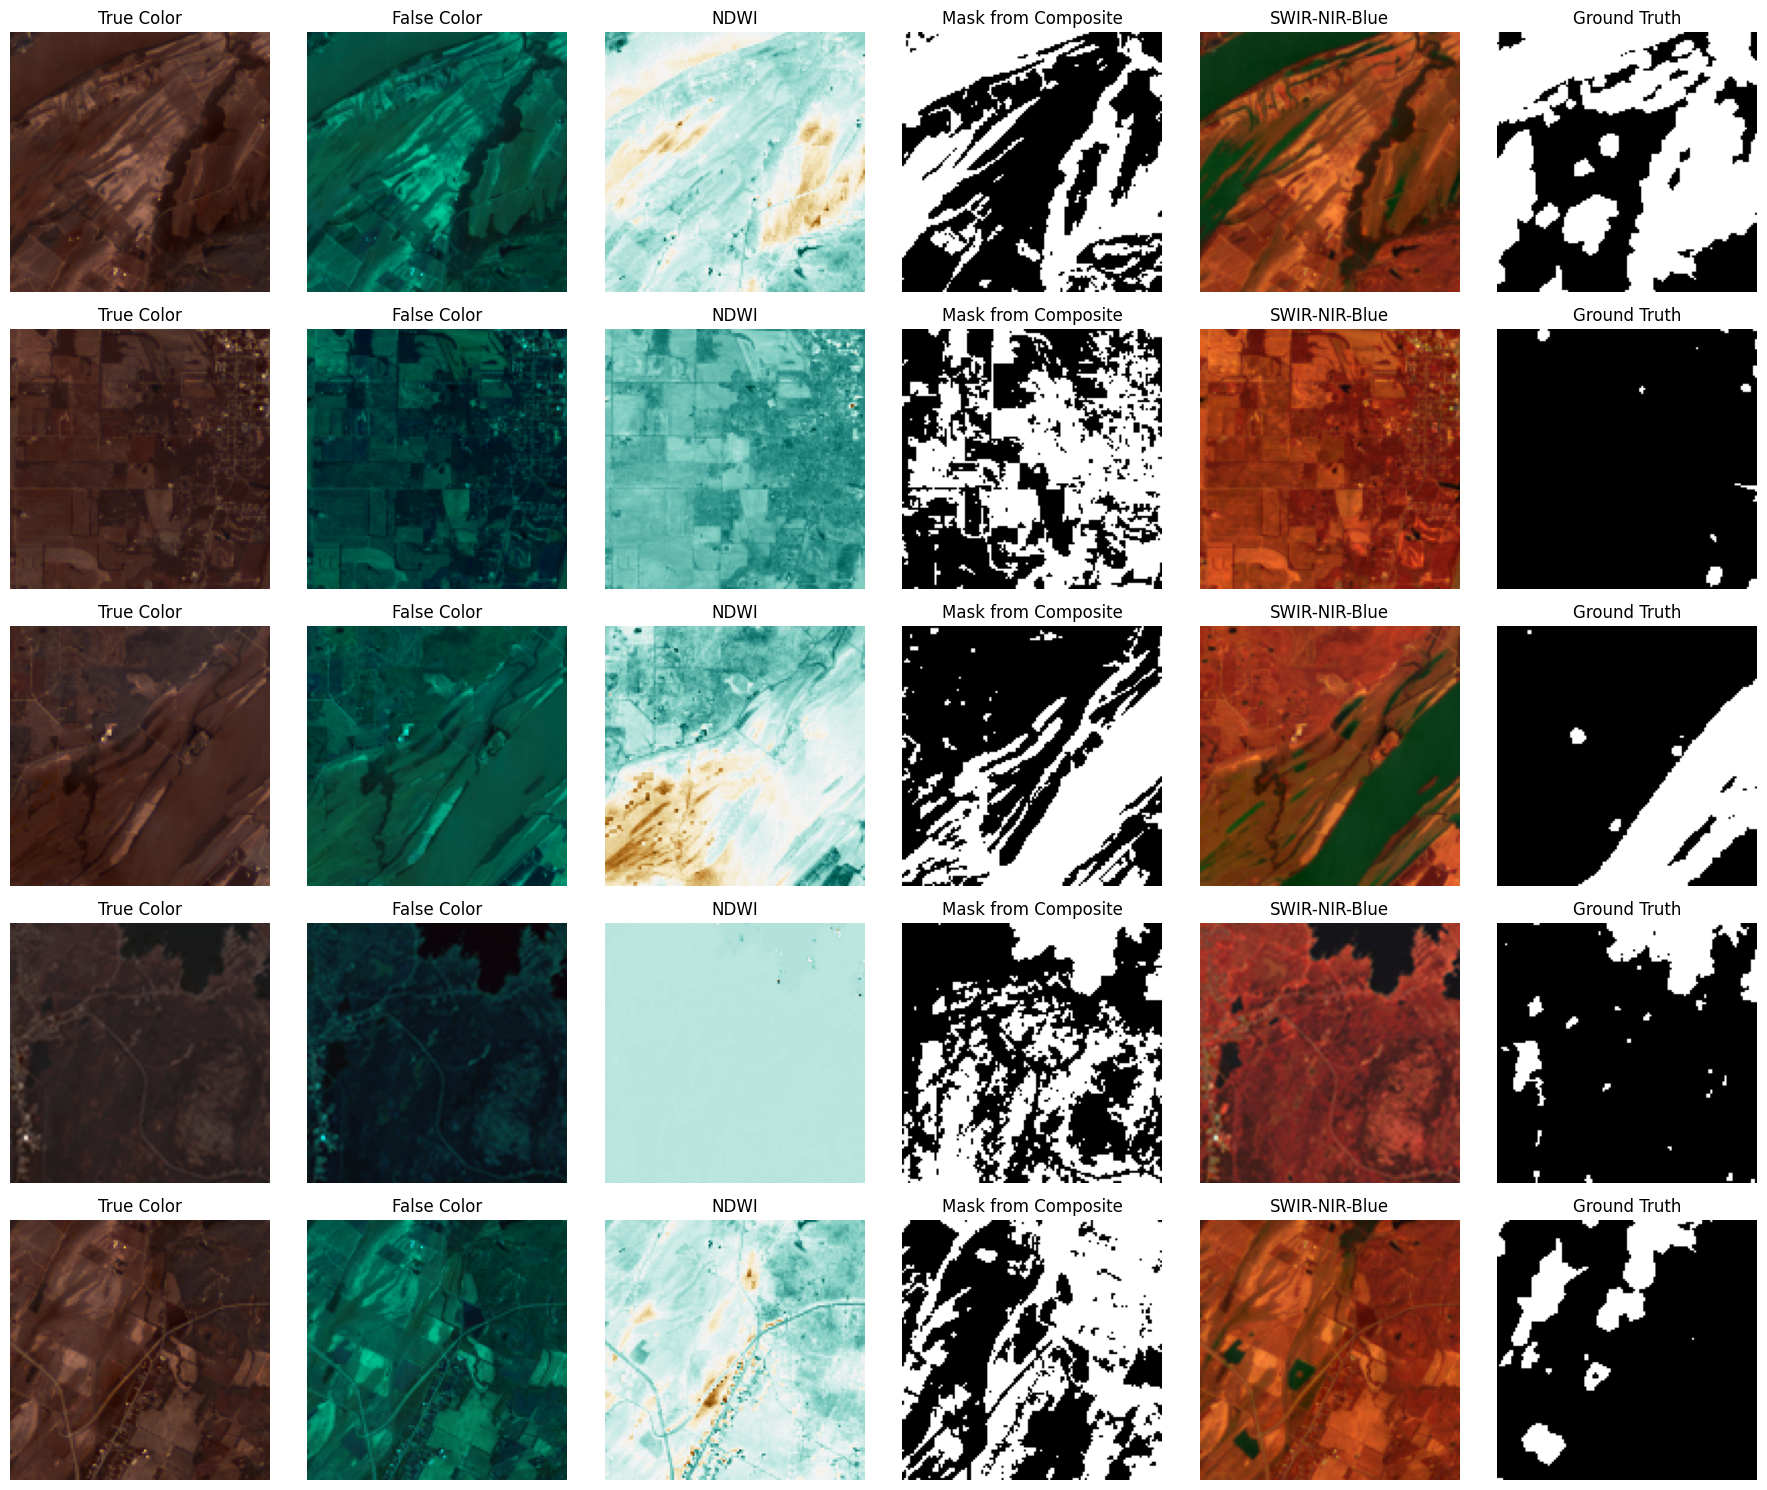

In [3]:

# Load paths
image_paths = sorted(glob("/content/drive/MyDrive/Water Segmentation/data/images/*.tif"))
label_paths = sorted(glob("/content/drive/MyDrive/Water Segmentation/data/labels/*.png"))

# Match by base filename
image_dict = {os.path.splitext(os.path.basename(p))[0]: p for p in image_paths}
label_dict = {os.path.splitext(os.path.basename(p))[0]: p for p in label_paths}
common_keys = sorted(set(image_dict.keys()) & set(label_dict.keys()))
matched_image_paths = [image_dict[k] for k in common_keys]
matched_label_paths = [label_dict[k] for k in common_keys]

# Random sample
num_samples = 5
random_indices = random.sample(range(len(matched_image_paths)), num_samples)

plt.figure(figsize=(18, num_samples * 3))

for row, idx in enumerate(random_indices):
    image = tiff.imread(matched_image_paths[idx])
    label = cv2.imread(matched_label_paths[idx], cv2.IMREAD_GRAYSCALE)

    # ----- True Color -----
    rgb = image[:, :, [2, 1, 0]].astype(np.float32)
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-8)
    plt.subplot(num_samples, 6, row * 6 + 1)
    plt.imshow(rgb)
    plt.title("True Color")
    plt.axis("off")

    # ----- False Color -----
    false_color = image[:, :, [7, 3, 2]].astype(np.float32)
    false_color = (false_color - false_color.min()) / (false_color.max() - false_color.min() + 1e-8)
    plt.subplot(num_samples, 6, row * 6 + 2)
    plt.imshow(false_color)
    plt.title("False Color")
    plt.axis("off")

    # ----- NDWI -----
    green = image[:, :, 1].astype(np.float32)
    nir = image[:, :, 3].astype(np.float32)
    ndwi = (green - nir) / (green + nir + 1e-8)
    plt.subplot(num_samples, 6, row * 6 + 3)
    plt.imshow(ndwi, cmap='BrBG')
    plt.title("NDWI")
    plt.axis("off")

    # ----- Custom Mask from Blue + NIR + SWIR -----
    blue = image[:, :, 0].astype(np.float32)
    nir = image[:, :, 3].astype(np.float32)
    swir = image[:, :, 5].astype(np.float32)

    # Stack into RGB-like composite: R=SWIR, G=NIR, B=Blue
    composite = np.stack([swir, nir, blue], axis=2)
    composite_norm = (composite - composite.min()) / (composite.max() - composite.min() + 1e-8)

    # Convert to grayscale
    gray = composite_norm.mean(axis=2)

    # ----- RGB Composite (SWIR-NIR-Blue) -----
    composite_rgb = composite_norm
    plt.subplot(num_samples, 6, row * 6 + 5)
    plt.imshow(composite_rgb)
    plt.title("SWIR-NIR-Blue")
    plt.axis("off")


     # Apply threshold (can be tuned)
    threshold = np.mean(gray) - 0.1 * np.std(gray)
    custom_mask = gray < threshold  # you can flip to > if needed

    plt.subplot(num_samples, 6, row * 6 + 4)
    plt.imshow(custom_mask, cmap='gray')
    plt.title("Mask from Composite")
    plt.axis("off")

    # ----- Ground Truth -----
    plt.subplot(num_samples, 6, row * 6 + 6)
    plt.imshow(label, cmap='gray')
    plt.title("Ground Truth")
    plt.axis("off")

plt.tight_layout()
plt.show()


# 📊 Plotting the 12 Spectral Bands
- Visualizes all 12 input bands from one image in the validation dataset.
- Each band is displayed in grayscale to observe patterns and distributions.
- Helps inspect differences in brightness, texture, and signal range between bands.


In [4]:
# Print the shape of the image (Height x Width x Bands)
print("Image shape:", image.shape)

# Print the shape of the label (Height x Width)
print("Label shape:", label.shape)

# Print the unique values in the label mask (should typically be 0 and 1 for binary segmentation)
print("Unique label values:", np.unique(label))


Image shape: (128, 128, 12)
Label shape: (128, 128)
Unique label values: [0 1]


# 🧾 WaterSegmentationDataset Summary

- Custom PyTorch `Dataset` for loading 12-band multispectral images and binary masks.
- Supports optional Albumentations transforms for data augmentation.
- Returns image and mask tensors in shapes `(12, H, W)` and `(1, H, W)` respectively.
- Designed for water segmentation tasks in satellite imagery.


In [5]:
class WaterSegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None, selected_bands=None):
        """
        image_paths: قائمة مسارات الصور
        mask_paths: قائمة مسارات الأقنعة
        transform: تحويلات albumentations (اختياري)
        selected_bands: قائمة أرقام القنوات التي تريد استخدامها (1-based indexing مثل [1, 2, 4])
                        إذا كانت None، سيتم استخدام كل القنوات
        """
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.selected_bands = selected_bands

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # تحميل الصورة متعددة القنوات
        with rasterio.open(self.image_paths[idx]) as src:
            if self.selected_bands:
                image = src.read(self.selected_bands)  # selected bands
            else:
                image = src.read()  # كل القنوات

        # تحميل القناع وتحويله إلى ثنائي
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.uint8)

        # تحويل الصورة إلى HWC
        image = np.transpose(image, (1, 2, 0)).astype(np.float32)  # (H, W, C)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']           # (C, H, W)
            mask = augmented['mask'].unsqueeze(0)  # (1, H, W)
        else:
            image = torch.tensor(image, dtype=torch.float).permute(2, 0, 1)
            mask = torch.tensor(mask, dtype=torch.float).unsqueeze(0)

        return image, mask


### 🧪 `train_transform` – Data Augmentation Pipeline

This Albumentations pipeline is used to augment training images and masks to improve model generalization.

In [6]:

image_dict = {os.path.splitext(os.path.basename(p))[0]: p for p in image_paths}
label_dict = {os.path.splitext(os.path.basename(p))[0]: p for p in label_paths}

common_keys = sorted(set(image_dict.keys()) & set(label_dict.keys()))

matched_images = [image_dict[k] for k in common_keys]
matched_labels = [label_dict[k] for k in common_keys]

print(f"Total matched pairs: {len(matched_images)}")

Total matched pairs: 306


In [7]:
# Split the matched image and mask pairs into training and validation sets (80% train, 20% val)

train_imgs, val_imgs, train_labels, val_labels = train_test_split(
    matched_images, matched_labels, test_size=0.2, random_state=42
)

print(f"Train: {len(train_imgs)} | Val: {len(val_imgs)}")


Train: 244 | Val: 62


# 🧹 Dataset & DataLoader Configuration

- #️⃣ Creates PyTorch-compatible datasets using `WaterSegmentationDataset`.
- 📊 `train_dataset` and `val_dataset` are initialized with image and mask paths.
- ⚙️ No data augmentation (`transform=None`) at this stage.
- 🚚 `DataLoader` wraps each dataset for batch processing:
  - `train_loader`: Batches of 4, data shuffled for training.
  - `val_loader`: Batches of 4, no shuffling for consistent validation.

This setup ensures efficient batch-wise training and validation of the segmentation model.


In [8]:
# Define selected bands (None means use all 12 bands)
selected_bands = None  # or for example: [0, 1, 2, 3]

# Function to get number of input channels
def get_in_channels(selected_bands):
    return 12 if selected_bands is None else len(selected_bands)

In [9]:
train_dataset = dataset = WaterSegmentationDataset(train_imgs, train_labels, transform=None, selected_bands=None)
val_dataset   = dataset = WaterSegmentationDataset(val_imgs, val_labels, transform=None, selected_bands=None)

g = torch.Generator()
g.manual_seed(42)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True , generator=g)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False)


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


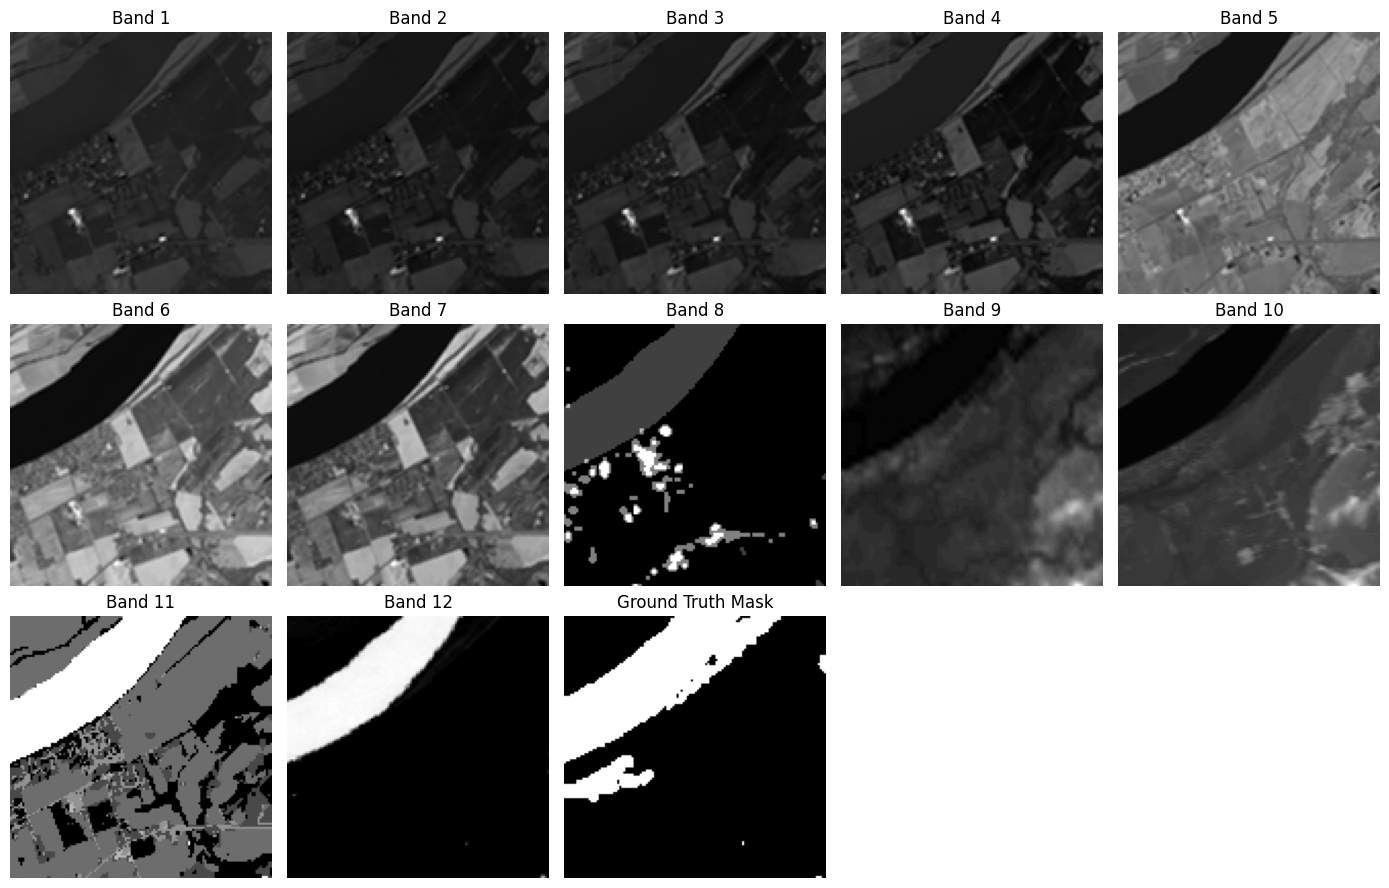

In [10]:
# Function to visualize all 12 bands of a single image + its mask
def plot_12_band_image_with_mask(image_tensor, mask_tensor):
    """
    Displays all 12 bands from an image along with its corresponding mask.
    Input image shape: (12, H, W)
    Input mask shape: (1, H, W) or (H, W)
    """
    # Convert tensors to numpy arrays
    if isinstance(image_tensor, torch.Tensor):
        image_tensor = image_tensor.cpu().numpy()
    if isinstance(mask_tensor, torch.Tensor):
        mask_tensor = mask_tensor.cpu().numpy()
        if mask_tensor.ndim == 3:
            mask_tensor = mask_tensor[0]  # Remove channel dim if exists

    # Plot 12 bands + 1 mask (total 13 subplots)
    plt.figure(figsize=(14, 9))
    for i in range(12):
        plt.subplot(3, 5, i + 1)
        plt.imshow(image_tensor[i], cmap='gray')
        plt.title(f'Band {i+1}')
        plt.axis('off')

    # Plot the mask at the end
    plt.subplot(3, 5, 13)
    plt.imshow(mask_tensor, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display the image and its mask from the first batch of validation set
for images, masks in val_loader:
    plot_12_band_image_with_mask(images[1], masks[1])
    break


In [11]:
def print_band_statistics(image_tensor):
    """
    Print mean, median, std, min, max for each of the 12 bands.
    image_tensor: torch.Tensor or np.ndarray of shape (12, H, W)
    """
    if isinstance(image_tensor, torch.Tensor):
        image_tensor = image_tensor.cpu().numpy()

    print("=== Band Statistics ===")
    for i in range(12):
        band = image_tensor[i]
        mean_val = band.mean()
        median_val = np.median(band)
        std_val = band.std()
        min_val = band.min()
        max_val = band.max()

        print(f"Band {i+1:>2}: Mean={mean_val:.4f} | Median={median_val:.4f} | Std={std_val:.4f} | Min={min_val:.4f} | Max={max_val:.4f}")

# Example usage on a sample from val_loader
for images, masks in val_loader:
    print_band_statistics(images[1])
    break


=== Band Statistics ===
Band  1: Mean=542.6429 | Median=465.0000 | Std=265.7990 | Min=-353.0000 | Max=5062.0000
Band  2: Mean=645.0996 | Median=552.0000 | Std=319.6436 | Min=-53.0000 | Max=5654.0000
Band  3: Mean=1011.8854 | Median=919.0000 | Std=400.9323 | Min=197.0000 | Max=6382.0000
Band  4: Mean=1122.3669 | Median=915.0000 | Std=583.5602 | Min=94.0000 | Max=7011.0000
Band  5: Mean=2704.5923 | Median=2987.5000 | Std=1158.3784 | Min=-166.0000 | Max=7331.0000
Band  6: Mean=2400.5928 | Median=2433.0000 | Std=1321.6266 | Min=-215.0000 | Max=5903.0000
Band  7: Mean=1745.3956 | Median=1587.0000 | Std=1155.5490 | Min=-251.0000 | Max=5581.0000
Band  8: Mean=74.1289 | Median=64.0000 | Std=22.9217 | Min=64.0000 | Max=192.0000
Band  9: Mean=120.5887 | Median=121.0000 | Std=4.6305 | Min=113.0000 | Max=156.0000
Band 10: Mean=120.3913 | Median=121.0000 | Std=7.4541 | Min=107.0000 | Max=170.0000
Band 11: Mean=40.0983 | Median=40.0000 | Std=20.8463 | Min=10.0000 | Max=80.0000
Band 12: Mean=14.3906 

# 🧹 Dataset & DataLoader Configuration

## 📁 Dataset Construction
- Uses `WaterSegmentationDataset` class to handle satellite `.tif` images and segmentation masks.
- `selected_bands` argument allows manual selection of specific spectral bands.
- Normalization is applied per band using:
  \[
  \text{normalized} = \frac{x - \min(x)}{\max(x) - \min(x) + 1e-8}
  \]

## 🎨 Data Augmentation
- Training data is augmented using `albumentations`:
  - Resize to 256×256
  - Horizontal & Vertical Flip
  - Random 90° Rotation
  - Shift, Scale, Rotate
  - Convert to PyTorch tensors with `ToTensorV2()`
- Validation data only resized and converted to tensor (no augmentation).

## 🚚 DataLoader Setup
- `train_loader_aug`:
  - Batch size: 8  
  - Shuffling: ✅ Enabled
- `val_loader_aug`:
  - Batch size: 8  
  - Shuffling: ❌ Disabled

# ✅ Purpose
- Ensures efficient training on normalized, multi-band satellite images.
- Augmentation enhances generalization during training.
- Validation is consistent and reproducible with fixed transforms.


In [12]:
# ✅ Normalization Function
def normalize_image(image_tensor):
    for i in range(image_tensor.shape[0]):
        band = image_tensor[i]
        image_tensor[i] = (band - band.min()) / (band.max() - band.min() + 1e-8)
    return image_tensor

# ✅ Albumentations Transforms
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256, 256),
    ToTensorV2()
])

train_dataset_aug =  WaterSegmentationDataset(train_imgs, train_labels, transform=train_transform, selected_bands=selected_bands)
val_dataset_aug = WaterSegmentationDataset(val_imgs, val_labels, transform=val_transform, selected_bands=selected_bands)


train_loader_aug = DataLoader(train_dataset_aug, batch_size=8, shuffle=True, num_workers=2)
val_loader_aug = DataLoader(val_dataset_aug, batch_size=8, shuffle=False, num_workers=2)

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [13]:
image_tensor, mask_tensor = train_dataset[10]

print("Image shape:", image_tensor.shape)
print("Mask shape :", mask_tensor.shape)

Image shape: torch.Size([12, 128, 128])
Mask shape : torch.Size([1, 128, 128])


# 🏋️ Training and Evaluation Functions

- 🔁 `train_one_epoch`: Handles one full training pass through the dataset using forward and backward propagation to optimize the model.

- 🧪 `evaluate`: Assesses model performance on the validation set without updating weights, calculating:
  - 📉 Validation Loss
  - 🧮 IoU (Intersection over Union)
  - 🎯 Accuracy
  - 💠 F1-Score

These functions form the core loop for training and validating the segmentation model.


In [14]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0

    for images, masks in tqdm(dataloader):
        images = images.to(device)
        masks = masks.to(device).float()

        # التمرير الأمامي
        outputs = model(images)
        loss = criterion(outputs, masks)

        # التمرير الخلفي والتحديث
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(dataloader)


def evaluate(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0
    total_iou = 0
    total_acc = 0
    total_f1 = 0
    num_batches = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device).float()

            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            # Apply sigmoid then threshold
            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()

            # Flatten predictions and masks
            preds_flat = preds.view(-1).cpu()
            masks_flat = masks.view(-1).cpu()

            # IoU
            intersection = (preds_flat * masks_flat).sum()
            union = preds_flat.sum() + masks_flat.sum() - intersection
            iou = (intersection / union).item() if union > 0 else 0
            total_iou += iou

            # Accuracy
            correct = (preds_flat == masks_flat).sum().item()
            total = masks_flat.numel()
            acc = correct / total
            total_acc += acc

            # F1 Score
            f1 = f1_score(masks_flat.numpy(), preds_flat.numpy(), zero_division=1)
            total_f1 += f1

            num_batches += 1

    avg_loss = val_loss / num_batches
    avg_iou = total_iou / num_batches
    avg_acc = total_acc / num_batches
    avg_f1 = total_f1 / num_batches

    return avg_loss, avg_iou, avg_acc, avg_f1



# 🧠 U-Net Architecture for Water Segmentation

Defines the U-Net model with the following components:

- 🔽 **Encoder**: Series of convolutional blocks and pooling layers to extract hierarchical features.
- 🔁 **Bottleneck**: Dense layer connecting encoder and decoder.
- 🔼 **Decoder**: Upsampling layers and skip connections for spatial reconstruction.
- 🎯 **Output Layer**: 1×1 convolution to map to binary mask logits.

Input: 12-band satellite image  
Output: Raw segmentation logits (before sigmoid)


In [15]:
class DoubleConv(nn.Module):
    """[Conv2D => BatchNorm => ReLU] * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=12, out_channels=1):
        super(UNet, self).__init__()

        # Encoder
        self.down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(512, 1024)

        # Decoder
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(1024, 512)

        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(512, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(256, 128)

        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        d1 = self.down1(x)
        d2 = self.down2(self.pool1(d1))
        d3 = self.down3(self.pool2(d2))
        d4 = self.down4(self.pool3(d3))

        # Bottleneck
        bn = self.bottleneck(self.pool4(d4))

        # Decoder
        up1 = self.up1(bn)
        up1 = torch.cat([up1, d4], dim=1)
        dec1 = self.dec1(up1)

        up2 = self.up2(dec1)
        up2 = torch.cat([up2, d3], dim=1)
        dec2 = self.dec2(up2)

        up3 = self.up3(dec2)
        up3 = torch.cat([up3, d2], dim=1)
        dec3 = self.dec3(up3)

        up4 = self.up4(dec3)
        up4 = torch.cat([up4, d1], dim=1)
        dec4 = self.dec4(up4)

        return self.final_conv(dec4)  # raw logits


In [16]:
# Create a tracking folder
tracking_dir = "/content/drive/MyDrive/mlruns"
os.makedirs(tracking_dir, exist_ok=True)



In [17]:
# Set tracking URI to local directory
mlflow.set_tracking_uri(f"file:{tracking_dir}")

# 🚀 Model Training Loop

This section handles the training process for 50 epochs:

- ⚙️ **Model Setup**: Initializes U-Net, optimizer (Adam), and loss function (BCEWithLogits).
- 🧠 **Training + Evaluation**: Each epoch trains on the training set and evaluates on the validation set.
- 📊 **Metric Tracking**: Saves loss, IoU, and F1 scores across epochs for visualization or analysis.


In [18]:
from rasterio.errors import NotGeoreferencedWarning
import warnings

# Suppress NotGeoreferencedWarning
warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)

num_epochs =50
in_channels = get_in_channels(selected_bands)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model = UNet(in_channels=in_channels, out_channels=1).to(device)
optimizer = torch.optim.Adam(base_model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

mlflow.set_experiment("UNet_Baseline")           # Create or use experiment

# Start logging
with mlflow.start_run(run_name="Unet") as run:

    # Log the model
    #mlflow.pytorch.log_model(base_model, "model")

    # Save model architecture to text
    with open("model_architecture.txt", "w") as f:
        f.write(str(base_model))

    # Log architecture file as artifact
    mlflow.log_artifact("model_architecture.txt")


    # Log parameters
    mlflow.log_param("model", "UNet")
    mlflow.log_param("in_channels", in_channels)
    mlflow.log_param("out_channels", 1)
    mlflow.log_param("epochs", num_epochs)
    mlflow.log_param("learning_rate", 1e-4)
    mlflow.log_param("loss_fn", "BCEWithLogitsLoss")
    mlflow.log_param("encoder_weights", "None")

    mlflow.log_param("augmentation" , "None")
    #mlflow.log_param("augmentation", "albumentations: HorizontalFlip, VerticalFlip, RandomRotate90, ShiftScaleRotate, Resize(256x256)")



    train_losses = []
    val_losses = []
    val_ious = []
    val_f1s = []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        train_loss = train_one_epoch(base_model, train_loader, optimizer, criterion, device)
        val_loss, val_iou, val_acc, val_f1 = evaluate(base_model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_ious.append(val_iou)
        val_f1s.append(val_f1)

        # Log metrics
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_iou", val_iou, step=epoch)
        mlflow.log_metric("val_f1", val_f1, step=epoch)

        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | IoU: {val_iou:.4f} | F1: {val_f1:.4f}")

    # Log final model
    mlflow.pytorch.log_model(base_model, "model")


2025/07/23 14:39:32 INFO mlflow.tracking.fluent: Experiment with name 'UNet_Baseline' does not exist. Creating a new experiment.



Epoch 1/50


100%|██████████| 61/61 [00:08<00:00,  7.09it/s]


Train Loss: 0.4624 | Val Loss: 0.3292 | IoU: 0.6210 | F1: 0.7548

Epoch 2/50


100%|██████████| 61/61 [00:12<00:00,  4.76it/s]


Train Loss: 0.3925 | Val Loss: 0.3329 | IoU: 0.6378 | F1: 0.7660

Epoch 3/50


100%|██████████| 61/61 [00:08<00:00,  7.58it/s]


Train Loss: 0.3660 | Val Loss: 0.3280 | IoU: 0.6137 | F1: 0.7447

Epoch 4/50


100%|██████████| 61/61 [00:07<00:00,  8.06it/s]


Train Loss: 0.3509 | Val Loss: 0.3150 | IoU: 0.6022 | F1: 0.7365

Epoch 5/50


100%|██████████| 61/61 [00:07<00:00,  7.80it/s]


Train Loss: 0.3199 | Val Loss: 0.2895 | IoU: 0.6472 | F1: 0.7773

Epoch 6/50


100%|██████████| 61/61 [00:07<00:00,  7.75it/s]


Train Loss: 0.3215 | Val Loss: 0.3025 | IoU: 0.6551 | F1: 0.7820

Epoch 7/50


100%|██████████| 61/61 [00:07<00:00,  7.84it/s]


Train Loss: 0.3078 | Val Loss: 0.3118 | IoU: 0.6457 | F1: 0.7745

Epoch 8/50


100%|██████████| 61/61 [00:07<00:00,  7.94it/s]


Train Loss: 0.3002 | Val Loss: 0.2503 | IoU: 0.6541 | F1: 0.7778

Epoch 9/50


100%|██████████| 61/61 [00:08<00:00,  7.56it/s]


Train Loss: 0.2798 | Val Loss: 0.2343 | IoU: 0.6676 | F1: 0.7878

Epoch 10/50


100%|██████████| 61/61 [00:08<00:00,  7.33it/s]


Train Loss: 0.2919 | Val Loss: 0.2404 | IoU: 0.6457 | F1: 0.7695

Epoch 11/50


100%|██████████| 61/61 [00:07<00:00,  7.68it/s]


Train Loss: 0.2694 | Val Loss: 0.2353 | IoU: 0.6583 | F1: 0.7827

Epoch 12/50


100%|██████████| 61/61 [00:08<00:00,  7.43it/s]


Train Loss: 0.2637 | Val Loss: 0.2092 | IoU: 0.6575 | F1: 0.7784

Epoch 13/50


100%|██████████| 61/61 [00:07<00:00,  7.75it/s]


Train Loss: 0.2740 | Val Loss: 0.2079 | IoU: 0.6683 | F1: 0.7912

Epoch 14/50


100%|██████████| 61/61 [00:08<00:00,  7.60it/s]


Train Loss: 0.2529 | Val Loss: 0.2053 | IoU: 0.7020 | F1: 0.8199

Epoch 15/50


100%|██████████| 61/61 [00:07<00:00,  7.90it/s]


Train Loss: 0.2628 | Val Loss: 0.2196 | IoU: 0.6640 | F1: 0.7857

Epoch 16/50


100%|██████████| 61/61 [00:07<00:00,  7.88it/s]


Train Loss: 0.2346 | Val Loss: 0.1920 | IoU: 0.6946 | F1: 0.8124

Epoch 17/50


100%|██████████| 61/61 [00:08<00:00,  7.59it/s]


Train Loss: 0.2438 | Val Loss: 0.2291 | IoU: 0.6785 | F1: 0.8014

Epoch 18/50


100%|██████████| 61/61 [00:07<00:00,  7.71it/s]


Train Loss: 0.2514 | Val Loss: 0.2108 | IoU: 0.6669 | F1: 0.7868

Epoch 19/50


100%|██████████| 61/61 [00:07<00:00,  8.07it/s]


Train Loss: 0.2340 | Val Loss: 0.2018 | IoU: 0.7112 | F1: 0.8253

Epoch 20/50


100%|██████████| 61/61 [00:07<00:00,  7.76it/s]


Train Loss: 0.2462 | Val Loss: 0.2253 | IoU: 0.6319 | F1: 0.7605

Epoch 21/50


100%|██████████| 61/61 [00:07<00:00,  7.71it/s]


Train Loss: 0.2371 | Val Loss: 0.1718 | IoU: 0.7048 | F1: 0.8161

Epoch 22/50


100%|██████████| 61/61 [00:07<00:00,  7.80it/s]


Train Loss: 0.2275 | Val Loss: 0.2243 | IoU: 0.6751 | F1: 0.8024

Epoch 23/50


100%|██████████| 61/61 [00:07<00:00,  7.92it/s]


Train Loss: 0.2463 | Val Loss: 0.1875 | IoU: 0.7043 | F1: 0.8195

Epoch 24/50


100%|██████████| 61/61 [00:08<00:00,  7.42it/s]


Train Loss: 0.2239 | Val Loss: 0.1786 | IoU: 0.7367 | F1: 0.8431

Epoch 25/50


100%|██████████| 61/61 [00:07<00:00,  7.72it/s]


Train Loss: 0.2338 | Val Loss: 0.1764 | IoU: 0.6912 | F1: 0.8010

Epoch 26/50


100%|██████████| 61/61 [00:07<00:00,  7.93it/s]


Train Loss: 0.2128 | Val Loss: 0.1763 | IoU: 0.7149 | F1: 0.8266

Epoch 27/50


100%|██████████| 61/61 [00:07<00:00,  8.02it/s]


Train Loss: 0.2130 | Val Loss: 0.1771 | IoU: 0.7233 | F1: 0.8306

Epoch 28/50


100%|██████████| 61/61 [00:07<00:00,  7.70it/s]


Train Loss: 0.2051 | Val Loss: 0.1711 | IoU: 0.7372 | F1: 0.8437

Epoch 29/50


100%|██████████| 61/61 [00:07<00:00,  7.77it/s]


Train Loss: 0.2156 | Val Loss: 0.2018 | IoU: 0.6665 | F1: 0.7851

Epoch 30/50


100%|██████████| 61/61 [00:07<00:00,  8.02it/s]


Train Loss: 0.2059 | Val Loss: 0.1592 | IoU: 0.7535 | F1: 0.8523

Epoch 31/50


100%|██████████| 61/61 [00:07<00:00,  7.78it/s]


Train Loss: 0.2154 | Val Loss: 0.1662 | IoU: 0.7334 | F1: 0.8380

Epoch 32/50


100%|██████████| 61/61 [00:07<00:00,  7.69it/s]


Train Loss: 0.2027 | Val Loss: 0.1863 | IoU: 0.7280 | F1: 0.8333

Epoch 33/50


100%|██████████| 61/61 [00:07<00:00,  7.84it/s]


Train Loss: 0.1989 | Val Loss: 0.1383 | IoU: 0.7738 | F1: 0.8682

Epoch 34/50


100%|██████████| 61/61 [00:07<00:00,  7.82it/s]


Train Loss: 0.2003 | Val Loss: 0.1600 | IoU: 0.7319 | F1: 0.8322

Epoch 35/50


100%|██████████| 61/61 [00:08<00:00,  7.58it/s]


Train Loss: 0.1826 | Val Loss: 0.1507 | IoU: 0.7570 | F1: 0.8551

Epoch 36/50


100%|██████████| 61/61 [00:08<00:00,  7.62it/s]


Train Loss: 0.1936 | Val Loss: 0.1679 | IoU: 0.6883 | F1: 0.7875

Epoch 37/50


100%|██████████| 61/61 [00:08<00:00,  7.42it/s]


Train Loss: 0.1946 | Val Loss: 0.1761 | IoU: 0.7403 | F1: 0.8469

Epoch 38/50


100%|██████████| 61/61 [00:07<00:00,  7.77it/s]


Train Loss: 0.1916 | Val Loss: 0.1724 | IoU: 0.7577 | F1: 0.8581

Epoch 39/50


100%|██████████| 61/61 [00:08<00:00,  7.56it/s]


Train Loss: 0.1840 | Val Loss: 0.1596 | IoU: 0.7513 | F1: 0.8518

Epoch 40/50


100%|██████████| 61/61 [00:07<00:00,  7.64it/s]


Train Loss: 0.1917 | Val Loss: 0.1831 | IoU: 0.7329 | F1: 0.8395

Epoch 41/50


100%|██████████| 61/61 [00:07<00:00,  7.85it/s]


Train Loss: 0.1721 | Val Loss: 0.1366 | IoU: 0.7807 | F1: 0.8728

Epoch 42/50


100%|██████████| 61/61 [00:07<00:00,  7.70it/s]


Train Loss: 0.1747 | Val Loss: 0.1636 | IoU: 0.7191 | F1: 0.8274

Epoch 43/50


100%|██████████| 61/61 [00:07<00:00,  7.70it/s]


Train Loss: 0.1701 | Val Loss: 0.1335 | IoU: 0.7560 | F1: 0.8489

Epoch 44/50


100%|██████████| 61/61 [00:07<00:00,  7.70it/s]


Train Loss: 0.1646 | Val Loss: 0.1429 | IoU: 0.7679 | F1: 0.8619

Epoch 45/50


100%|██████████| 61/61 [00:07<00:00,  7.90it/s]


Train Loss: 0.1562 | Val Loss: 0.1381 | IoU: 0.7781 | F1: 0.8716

Epoch 46/50


100%|██████████| 61/61 [00:08<00:00,  7.62it/s]


Train Loss: 0.1496 | Val Loss: 0.1325 | IoU: 0.7704 | F1: 0.8639

Epoch 47/50


100%|██████████| 61/61 [00:08<00:00,  7.59it/s]


Train Loss: 0.1460 | Val Loss: 0.1379 | IoU: 0.7303 | F1: 0.8339

Epoch 48/50


100%|██████████| 61/61 [00:07<00:00,  7.75it/s]


Train Loss: 0.1442 | Val Loss: 0.1337 | IoU: 0.7852 | F1: 0.8754

Epoch 49/50


100%|██████████| 61/61 [00:08<00:00,  7.29it/s]


Train Loss: 0.1418 | Val Loss: 0.1248 | IoU: 0.7750 | F1: 0.8675

Epoch 50/50


100%|██████████| 61/61 [00:08<00:00,  7.55it/s]
2025/07/23 14:47:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Train Loss: 0.1404 | Val Loss: 0.1416 | IoU: 0.7272 | F1: 0.8264


2025/07/23 14:47:44 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/07/23 14:47:51 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/07/23 14:47:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.

























# 📈 Training Performance Visualization

This section plots model performance across epochs:

- **Loss Chart**: Shows training vs. validation loss to monitor overfitting or convergence.
- **IoU & F1 Score Chart**: Visualizes how well the model segments across epochs using Intersection over Union and F1 score.


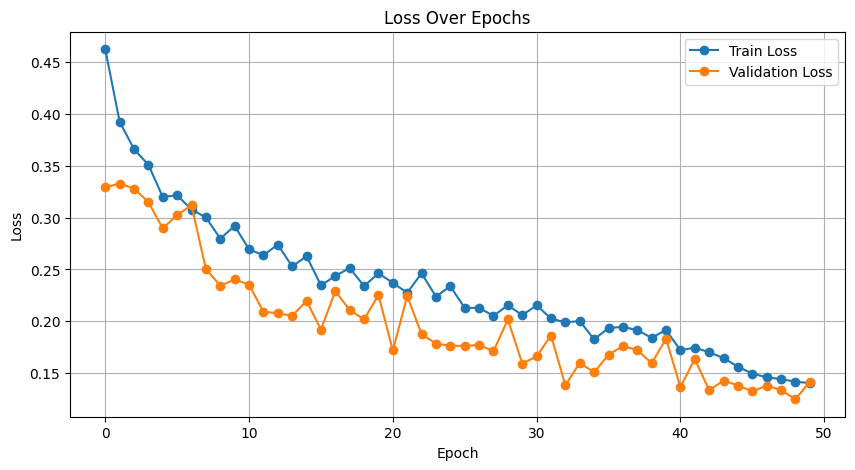

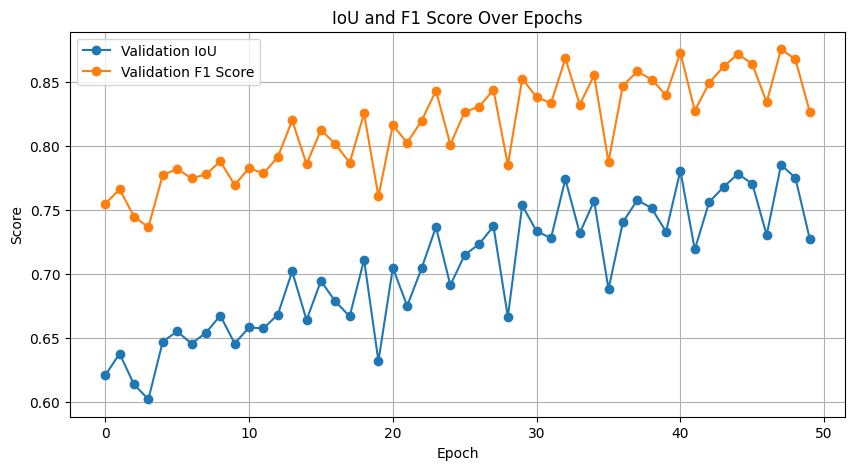

In [19]:
# Loss Chart
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# IoU & F1 Chart
plt.figure(figsize=(10, 5))
plt.plot(val_ious, label='Validation IoU', marker='o')
plt.plot(val_f1s, label='Validation F1 Score', marker='o')
plt.title("IoU and F1 Score Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

# 🖼️ Sample Prediction Visualization

This cell performs a forward pass on a validation image to visualize:

- The **input image** (converted from 12-band to RGB using bands 3, 2, 1).
- The **ground truth mask**.
- The **predicted mask** from the model after sigmoid and thresholding.

This helps qualitatively evaluate how well the model is segmenting water regions.


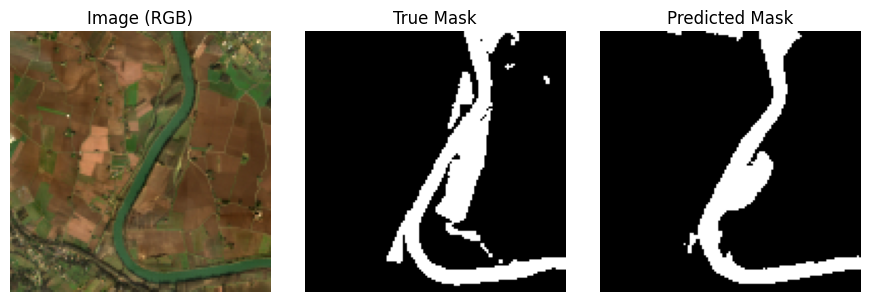

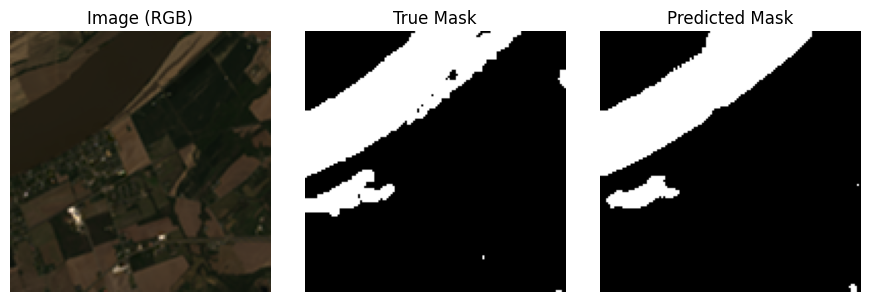

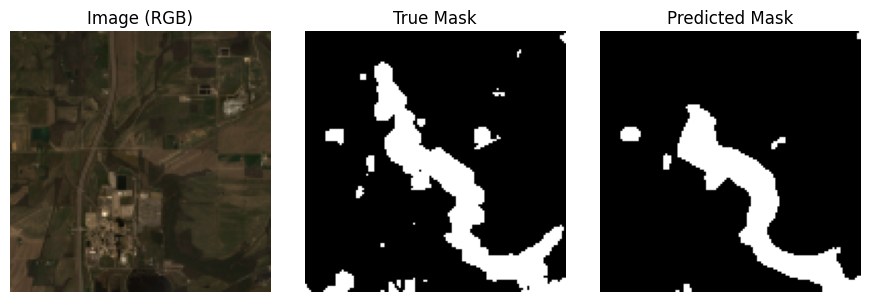

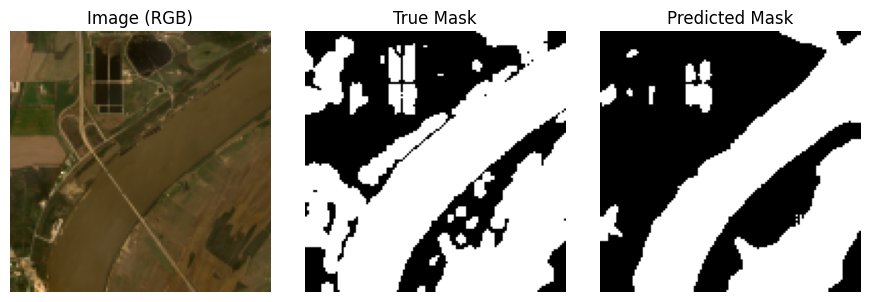

In [20]:
base_model.eval()
with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = base_model(images)
        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()

        for i in range(4):  # Show first 4 samples
            # Extract RGB bands (3,2,1) and normalize
            rgb = images[i][[3, 2, 1]].cpu().permute(1, 2, 0).numpy()
            rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-6)  # Normalize to [0,1]

            true_mask = masks[i][0].cpu().numpy()
            pred_mask = preds[i][0].cpu().numpy()

            plt.figure(figsize=(9,3))
            plt.subplot(1,3,1); plt.title("Image (RGB)"); plt.imshow(rgb); plt.axis("off")
            plt.subplot(1,3,2); plt.title("True Mask"); plt.imshow(true_mask, cmap='gray'); plt.axis("off")
            plt.subplot(1,3,3); plt.title("Predicted Mask"); plt.imshow(pred_mask, cmap='gray'); plt.axis("off")
            plt.tight_layout()
            plt.show()
        break


### 🧪 Evaluation Metrics Function

This section defines and runs evaluation logic for the trained model.

- `compute_metrics`:  
  Calculates standard segmentation metrics — Accuracy, Precision, Recall, F1 Score, and IoU — from predicted and ground truth masks using a configurable threshold (default: 0.5).

- `evaluate_metrics`:  
  Loops over the validation dataloader to:
  - Collect predictions from the model
  - Compute metrics batch-wise using `compute_metrics`
  - Aggregate and print the average results across the entire dataset.

➡️ Final output displays **mean Accuracy, Precision, Recall, F1-Score, and IoU** for validation performance.


In [21]:
def compute_metrics(preds, targets, threshold=0.5):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()

    preds = preds.cpu().numpy().astype(int)
    targets = targets.cpu().numpy().astype(int)

    TP = (preds * targets).sum()
    TN = ((1 - preds) * (1 - targets)).sum()
    FP = (preds * (1 - targets)).sum()
    FN = ((1 - preds) * targets).sum()

    epsilon = 1e-7

    accuracy = (TP + TN) / (TP + TN + FP + FN + epsilon)
    precision = TP / (TP + FP + epsilon)
    recall = TP / (TP + FN + epsilon)
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)
    iou = TP / (TP + FP + FN + epsilon)

    return accuracy, precision, recall, f1, iou

def evaluate_metrics(model, dataloader, device):
    model.eval()
    total_acc, total_prec, total_rec, total_f1, total_iou = 0, 0, 0, 0, 0
    n_batches = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            acc, prec, rec, f1, iou = compute_metrics(outputs, masks)

            total_acc += acc
            total_prec += prec
            total_rec += rec
            total_f1 += f1
            total_iou += iou
            n_batches += 1

    print("=== Evaluation Metrics ===")
    print(f"Accuracy : {total_acc / n_batches:.4f}")
    print(f"Precision: {total_prec / n_batches:.4f}")
    print(f"Recall   : {total_rec / n_batches:.4f}")
    print(f"F1-Score : {total_f1 / n_batches:.4f}")
    print(f"IoU      : {total_iou / n_batches:.4f}")



evaluate_metrics(base_model, val_loader, device)


=== Evaluation Metrics ===
Accuracy : 0.9447
Precision: 0.9309
Recall   : 0.7645
F1-Score : 0.8264
IoU      : 0.7272


In [22]:
from rasterio.errors import NotGeoreferencedWarning
import warnings

# Suppress NotGeoreferencedWarning
warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)

num_epochs =50
in_channels = get_in_channels(selected_bands)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model = UNet(in_channels=in_channels, out_channels=1).to(device)
optimizer = torch.optim.Adam(base_model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

mlflow.set_experiment("UNet_Baseline")           # Create or use experiment

# Start logging
with mlflow.start_run(run_name="Unet_Aug") as run:

    # Log the model
    #mlflow.pytorch.log_model(base_model, "model")

    # Save model architecture to text
    with open("model_architecture.txt", "w") as f:
        f.write(str(base_model))

    # Log architecture file as artifact
    #mlflow.log_artifact("model_architecture.txt")


    # Log parameters
    mlflow.log_param("model", "UNet")
    mlflow.log_param("in_channels", in_channels)
    mlflow.log_param("out_channels", 1)
    mlflow.log_param("epochs", num_epochs)
    mlflow.log_param("learning_rate", 1e-4)
    mlflow.log_param("loss_function", "BCEWithLogitsLoss")
    #mlflow.log_param("augmentation" , "None")
    mlflow.log_param("encoder_weights", "None")

    mlflow.log_param("augmentation", "albumentations: HorizontalFlip, VerticalFlip, RandomRotate90, ShiftScaleRotate, Resize(256x256)")



    train_losses = []
    val_losses = []
    val_ious = []
    val_f1s = []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        train_loss = train_one_epoch(base_model, train_loader_aug, optimizer, criterion, device)
        val_loss, val_iou, val_acc, val_f1 = evaluate(base_model, val_loader_aug, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_ious.append(val_iou)
        val_f1s.append(val_f1)

        # Log metrics
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_iou", val_iou, step=epoch)
        mlflow.log_metric("val_f1", val_f1, step=epoch)

        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | IoU: {val_iou:.4f} | F1: {val_f1:.4f}")

    # Log final model
    mlflow.pytorch.log_model(base_model, "model")



Epoch 1/50


100%|██████████| 31/31 [00:15<00:00,  2.01it/s]


Train Loss: 0.5086 | Val Loss: 0.4740 | IoU: 0.5741 | F1: 0.7238

Epoch 2/50


100%|██████████| 31/31 [00:15<00:00,  1.98it/s]


Train Loss: 0.3975 | Val Loss: 0.3370 | IoU: 0.6213 | F1: 0.7571

Epoch 3/50


100%|██████████| 31/31 [00:15<00:00,  2.00it/s]


Train Loss: 0.3734 | Val Loss: 0.3138 | IoU: 0.6221 | F1: 0.7581

Epoch 4/50


100%|██████████| 31/31 [00:15<00:00,  2.02it/s]


Train Loss: 0.3719 | Val Loss: 0.3153 | IoU: 0.6329 | F1: 0.7661

Epoch 5/50


100%|██████████| 31/31 [00:15<00:00,  2.03it/s]


Train Loss: 0.3412 | Val Loss: 0.2865 | IoU: 0.6246 | F1: 0.7600

Epoch 6/50


100%|██████████| 31/31 [00:15<00:00,  1.98it/s]


Train Loss: 0.3303 | Val Loss: 0.2880 | IoU: 0.6244 | F1: 0.7600

Epoch 7/50


100%|██████████| 31/31 [00:15<00:00,  2.01it/s]


Train Loss: 0.3193 | Val Loss: 0.3144 | IoU: 0.6287 | F1: 0.7637

Epoch 8/50


100%|██████████| 31/31 [00:15<00:00,  2.03it/s]


Train Loss: 0.3165 | Val Loss: 0.3017 | IoU: 0.6456 | F1: 0.7774

Epoch 9/50


100%|██████████| 31/31 [00:15<00:00,  1.97it/s]


Train Loss: 0.3090 | Val Loss: 0.2969 | IoU: 0.6154 | F1: 0.7520

Epoch 10/50


100%|██████████| 31/31 [00:15<00:00,  2.02it/s]


Train Loss: 0.3049 | Val Loss: 0.2452 | IoU: 0.6571 | F1: 0.7860

Epoch 11/50


100%|██████████| 31/31 [00:15<00:00,  2.02it/s]


Train Loss: 0.2974 | Val Loss: 0.2621 | IoU: 0.7004 | F1: 0.8171

Epoch 12/50


100%|██████████| 31/31 [00:15<00:00,  1.99it/s]


Train Loss: 0.2854 | Val Loss: 0.2672 | IoU: 0.6354 | F1: 0.7687

Epoch 13/50


100%|██████████| 31/31 [00:15<00:00,  2.03it/s]


Train Loss: 0.2857 | Val Loss: 0.2391 | IoU: 0.6804 | F1: 0.8051

Epoch 14/50


100%|██████████| 31/31 [00:15<00:00,  2.01it/s]


Train Loss: 0.2780 | Val Loss: 0.2416 | IoU: 0.6515 | F1: 0.7807

Epoch 15/50


100%|██████████| 31/31 [00:15<00:00,  2.02it/s]


Train Loss: 0.2693 | Val Loss: 0.2446 | IoU: 0.6831 | F1: 0.8068

Epoch 16/50


100%|██████████| 31/31 [00:15<00:00,  2.03it/s]


Train Loss: 0.2594 | Val Loss: 0.2314 | IoU: 0.6605 | F1: 0.7870

Epoch 17/50


100%|██████████| 31/31 [00:15<00:00,  2.01it/s]


Train Loss: 0.2641 | Val Loss: 0.2331 | IoU: 0.6694 | F1: 0.7939

Epoch 18/50


100%|██████████| 31/31 [00:15<00:00,  2.02it/s]


Train Loss: 0.2624 | Val Loss: 0.2225 | IoU: 0.6502 | F1: 0.7793

Epoch 19/50


100%|██████████| 31/31 [00:15<00:00,  2.00it/s]


Train Loss: 0.2673 | Val Loss: 0.2079 | IoU: 0.6561 | F1: 0.7837

Epoch 20/50


100%|██████████| 31/31 [00:15<00:00,  2.03it/s]


Train Loss: 0.2591 | Val Loss: 0.2022 | IoU: 0.6412 | F1: 0.7720

Epoch 21/50


100%|██████████| 31/31 [00:15<00:00,  2.03it/s]


Train Loss: 0.2464 | Val Loss: 0.2063 | IoU: 0.6985 | F1: 0.8171

Epoch 22/50


100%|██████████| 31/31 [00:15<00:00,  1.99it/s]


Train Loss: 0.2368 | Val Loss: 0.2089 | IoU: 0.6971 | F1: 0.8141

Epoch 23/50


100%|██████████| 31/31 [00:15<00:00,  2.02it/s]


Train Loss: 0.2332 | Val Loss: 0.2165 | IoU: 0.6353 | F1: 0.7685

Epoch 24/50


100%|██████████| 31/31 [00:15<00:00,  2.02it/s]


Train Loss: 0.2399 | Val Loss: 0.2392 | IoU: 0.6880 | F1: 0.8087

Epoch 25/50


100%|██████████| 31/31 [00:15<00:00,  1.97it/s]


Train Loss: 0.2375 | Val Loss: 0.1972 | IoU: 0.6526 | F1: 0.7809

Epoch 26/50


100%|██████████| 31/31 [00:15<00:00,  2.03it/s]


Train Loss: 0.2337 | Val Loss: 0.2052 | IoU: 0.7111 | F1: 0.8263

Epoch 27/50


100%|██████████| 31/31 [00:15<00:00,  2.02it/s]


Train Loss: 0.2280 | Val Loss: 0.1852 | IoU: 0.6771 | F1: 0.7995

Epoch 28/50


100%|██████████| 31/31 [00:15<00:00,  1.99it/s]


Train Loss: 0.2251 | Val Loss: 0.1889 | IoU: 0.6468 | F1: 0.7765

Epoch 29/50


100%|██████████| 31/31 [00:15<00:00,  2.03it/s]


Train Loss: 0.2279 | Val Loss: 0.2104 | IoU: 0.6722 | F1: 0.7951

Epoch 30/50


100%|██████████| 31/31 [00:15<00:00,  2.02it/s]


Train Loss: 0.2312 | Val Loss: 0.2059 | IoU: 0.6546 | F1: 0.7827

Epoch 31/50


100%|██████████| 31/31 [00:15<00:00,  2.01it/s]


Train Loss: 0.2213 | Val Loss: 0.1823 | IoU: 0.6726 | F1: 0.7959

Epoch 32/50


100%|██████████| 31/31 [00:15<00:00,  2.02it/s]


Train Loss: 0.2208 | Val Loss: 0.1994 | IoU: 0.6706 | F1: 0.7943

Epoch 33/50


100%|██████████| 31/31 [00:15<00:00,  2.03it/s]


Train Loss: 0.2269 | Val Loss: 0.2099 | IoU: 0.6385 | F1: 0.7704

Epoch 34/50


100%|██████████| 31/31 [00:15<00:00,  2.02it/s]


Train Loss: 0.2276 | Val Loss: 0.2128 | IoU: 0.6694 | F1: 0.7936

Epoch 35/50


100%|██████████| 31/31 [00:15<00:00,  2.00it/s]


Train Loss: 0.2247 | Val Loss: 0.1985 | IoU: 0.6744 | F1: 0.7980

Epoch 36/50


100%|██████████| 31/31 [00:15<00:00,  2.02it/s]


Train Loss: 0.2147 | Val Loss: 0.1816 | IoU: 0.6661 | F1: 0.7914

Epoch 37/50


100%|██████████| 31/31 [00:15<00:00,  2.03it/s]


Train Loss: 0.2114 | Val Loss: 0.1927 | IoU: 0.6866 | F1: 0.8076

Epoch 38/50


100%|██████████| 31/31 [00:15<00:00,  1.99it/s]


Train Loss: 0.2227 | Val Loss: 0.1719 | IoU: 0.6656 | F1: 0.7904

Epoch 39/50


100%|██████████| 31/31 [00:15<00:00,  2.02it/s]


Train Loss: 0.2146 | Val Loss: 0.1718 | IoU: 0.6678 | F1: 0.7921

Epoch 40/50


100%|██████████| 31/31 [00:15<00:00,  2.02it/s]


Train Loss: 0.2110 | Val Loss: 0.1900 | IoU: 0.6656 | F1: 0.7903

Epoch 41/50


100%|██████████| 31/31 [00:15<00:00,  1.98it/s]


Train Loss: 0.2106 | Val Loss: 0.1743 | IoU: 0.6583 | F1: 0.7850

Epoch 42/50


100%|██████████| 31/31 [00:15<00:00,  2.03it/s]


Train Loss: 0.2133 | Val Loss: 0.1662 | IoU: 0.6638 | F1: 0.7890

Epoch 43/50


100%|██████████| 31/31 [00:15<00:00,  2.02it/s]


Train Loss: 0.2062 | Val Loss: 0.1690 | IoU: 0.6843 | F1: 0.8050

Epoch 44/50


100%|██████████| 31/31 [00:15<00:00,  1.97it/s]


Train Loss: 0.2018 | Val Loss: 0.1758 | IoU: 0.6625 | F1: 0.7883

Epoch 45/50


100%|██████████| 31/31 [00:15<00:00,  2.02it/s]


Train Loss: 0.2113 | Val Loss: 0.1827 | IoU: 0.6704 | F1: 0.7932

Epoch 46/50


100%|██████████| 31/31 [00:15<00:00,  2.03it/s]


Train Loss: 0.2038 | Val Loss: 0.1940 | IoU: 0.7051 | F1: 0.8207

Epoch 47/50


100%|██████████| 31/31 [00:15<00:00,  2.00it/s]


Train Loss: 0.2038 | Val Loss: 0.1864 | IoU: 0.7137 | F1: 0.8271

Epoch 48/50


100%|██████████| 31/31 [00:15<00:00,  2.03it/s]


Train Loss: 0.1983 | Val Loss: 0.1677 | IoU: 0.6824 | F1: 0.8031

Epoch 49/50


100%|██████████| 31/31 [00:15<00:00,  2.01it/s]


Train Loss: 0.1906 | Val Loss: 0.1603 | IoU: 0.6800 | F1: 0.8010

Epoch 50/50


100%|██████████| 31/31 [00:15<00:00,  2.03it/s]
2025/07/23 15:03:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Train Loss: 0.1945 | Val Loss: 0.1615 | IoU: 0.6810 | F1: 0.8018


2025/07/23 15:03:05 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/07/23 15:03:09 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/07/23 15:03:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [23]:
def compute_metrics(preds, targets, threshold=0.5):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()

    preds = preds.cpu().numpy().astype(int)
    targets = targets.cpu().numpy().astype(int)

    TP = (preds * targets).sum()
    TN = ((1 - preds) * (1 - targets)).sum()
    FP = (preds * (1 - targets)).sum()
    FN = ((1 - preds) * targets).sum()

    epsilon = 1e-7

    accuracy = (TP + TN) / (TP + TN + FP + FN + epsilon)
    precision = TP / (TP + FP + epsilon)
    recall = TP / (TP + FN + epsilon)
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)
    iou = TP / (TP + FP + FN + epsilon)

    return accuracy, precision, recall, f1, iou

def evaluate_metrics(model, dataloader, device):
    model.eval()
    total_acc, total_prec, total_rec, total_f1, total_iou = 0, 0, 0, 0, 0
    n_batches = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            acc, prec, rec, f1, iou = compute_metrics(outputs, masks)

            total_acc += acc
            total_prec += prec
            total_rec += rec
            total_f1 += f1
            total_iou += iou
            n_batches += 1

    print("=== Evaluation Metrics ===")
    print(f"Accuracy : {total_acc / n_batches:.4f}")
    print(f"Precision: {total_prec / n_batches:.4f}")
    print(f"Recall   : {total_rec / n_batches:.4f}")
    print(f"F1-Score : {total_f1 / n_batches:.4f}")
    print(f"IoU      : {total_iou / n_batches:.4f}")



evaluate_metrics(base_model, val_loader_aug, device)


=== Evaluation Metrics ===
Accuracy : 0.9309
Precision: 0.9109
Recall   : 0.7241
F1-Score : 0.8018
IoU      : 0.6810


In [24]:
# ✅ Define the model using SMP with 12 input channels
model_DLV3 = smp.DeepLabV3(
    encoder_name="resnet34",        # Backbone
    encoder_weights="imagenet",     # Pretrained on ImageNet
    in_channels=12,                 # Your input channel count (e.g., 12 bands)
    classes=1                       # Output classes (binary segmentation)
)

model_DLV3.to(device)  # Send to GPU if available

# ✅ Define optimizer and loss
optimizer = optim.Adam(model_DLV3.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

# 🚀 Start MLflow run
with mlflow.start_run(run_name="DeepLabV3"):

    # 🧩 Log experiment parameters
    mlflow.log_param("model", "DeepLabV3_ResNet34")
    mlflow.log_param("in_channels", 12)
    mlflow.log_param("out_channels", 1)
    mlflow.log_param("epochs", num_epochs)
    mlflow.log_param("learning_rate", 1e-4)
    mlflow.log_param("loss_function", "BCEWithLogitsLoss")
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("encoder_weights", "imagenet")
    mlflow.log_param("augmentation", "None")

    # 📊 Metric containers
    train_losses, val_losses, val_ious, val_f1s = [], [], [], []

    # 🔁 Training loop
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # 🎯 Train
        train_loss = train_one_epoch(model_DLV3, train_loader, optimizer, criterion, device)

        # 🧪 Validate
        val_loss, val_iou, val_acc, val_f1 = evaluate(model_DLV3, val_loader, criterion, device)

        # 📉 Log to MLflow
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_iou", val_iou, step=epoch)
        mlflow.log_metric("val_f1", val_f1, step=epoch)

        # 📥 Append metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_ious.append(val_iou)
        val_f1s.append(val_f1)

        # 🖨️ Print
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | IoU: {val_iou:.4f} | F1: {val_f1:.4f}")

    # 💾 Log the model to MLflow
    mlflow.pytorch.log_model(model_DLV3, "model")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



Epoch 1/50


100%|██████████| 61/61 [00:08<00:00,  7.11it/s]


Train Loss: 0.4827 | Val Loss: 0.4587 | IoU: 0.4914 | F1: 0.6342

Epoch 2/50


100%|██████████| 61/61 [00:07<00:00,  8.66it/s]


Train Loss: 0.4088 | Val Loss: 0.3296 | IoU: 0.5757 | F1: 0.7044

Epoch 3/50


100%|██████████| 61/61 [00:07<00:00,  8.12it/s]


Train Loss: 0.3577 | Val Loss: 0.4054 | IoU: 0.5555 | F1: 0.6967

Epoch 4/50


100%|██████████| 61/61 [00:07<00:00,  8.04it/s]


Train Loss: 0.3149 | Val Loss: 0.3309 | IoU: 0.5601 | F1: 0.6826

Epoch 5/50


100%|██████████| 61/61 [00:07<00:00,  8.40it/s]


Train Loss: 0.2862 | Val Loss: 0.2130 | IoU: 0.6462 | F1: 0.7613

Epoch 6/50


100%|██████████| 61/61 [00:07<00:00,  8.40it/s]


Train Loss: 0.2494 | Val Loss: 0.2960 | IoU: 0.5781 | F1: 0.6925

Epoch 7/50


100%|██████████| 61/61 [00:07<00:00,  8.07it/s]


Train Loss: 0.2439 | Val Loss: 0.2011 | IoU: 0.6405 | F1: 0.7464

Epoch 8/50


100%|██████████| 61/61 [00:07<00:00,  8.45it/s]


Train Loss: 0.2337 | Val Loss: 0.1889 | IoU: 0.6565 | F1: 0.7678

Epoch 9/50


100%|██████████| 61/61 [00:07<00:00,  8.56it/s]


Train Loss: 0.2237 | Val Loss: 0.2378 | IoU: 0.6915 | F1: 0.8064

Epoch 10/50


100%|██████████| 61/61 [00:07<00:00,  8.24it/s]


Train Loss: 0.2268 | Val Loss: 0.3158 | IoU: 0.5798 | F1: 0.7082

Epoch 11/50


100%|██████████| 61/61 [00:07<00:00,  8.48it/s]


Train Loss: 0.2403 | Val Loss: 0.1918 | IoU: 0.6622 | F1: 0.7728

Epoch 12/50


100%|██████████| 61/61 [00:07<00:00,  8.55it/s]


Train Loss: 0.2072 | Val Loss: 0.2416 | IoU: 0.6979 | F1: 0.8145

Epoch 13/50


100%|██████████| 61/61 [00:07<00:00,  8.13it/s]


Train Loss: 0.1823 | Val Loss: 0.1688 | IoU: 0.7112 | F1: 0.8177

Epoch 14/50


100%|██████████| 61/61 [00:07<00:00,  7.66it/s]


Train Loss: 0.1709 | Val Loss: 0.1689 | IoU: 0.7558 | F1: 0.8562

Epoch 15/50


100%|██████████| 61/61 [00:07<00:00,  8.48it/s]


Train Loss: 0.1766 | Val Loss: 0.1598 | IoU: 0.7217 | F1: 0.8242

Epoch 16/50


100%|██████████| 61/61 [00:07<00:00,  8.29it/s]


Train Loss: 0.1581 | Val Loss: 0.1492 | IoU: 0.7382 | F1: 0.8388

Epoch 17/50


100%|██████████| 61/61 [00:07<00:00,  8.22it/s]


Train Loss: 0.1470 | Val Loss: 0.1408 | IoU: 0.7591 | F1: 0.8562

Epoch 18/50


100%|██████████| 61/61 [00:07<00:00,  8.59it/s]


Train Loss: 0.1388 | Val Loss: 0.1419 | IoU: 0.7513 | F1: 0.8500

Epoch 19/50


100%|██████████| 61/61 [00:07<00:00,  8.35it/s]


Train Loss: 0.1476 | Val Loss: 0.1350 | IoU: 0.7553 | F1: 0.8520

Epoch 20/50


100%|██████████| 61/61 [00:07<00:00,  8.21it/s]


Train Loss: 0.1324 | Val Loss: 0.1396 | IoU: 0.7499 | F1: 0.8493

Epoch 21/50


100%|██████████| 61/61 [00:07<00:00,  8.48it/s]


Train Loss: 0.1314 | Val Loss: 0.1358 | IoU: 0.7432 | F1: 0.8386

Epoch 22/50


100%|██████████| 61/61 [00:07<00:00,  8.30it/s]


Train Loss: 0.1270 | Val Loss: 0.1399 | IoU: 0.7729 | F1: 0.8669

Epoch 23/50


100%|██████████| 61/61 [00:07<00:00,  8.28it/s]


Train Loss: 0.1213 | Val Loss: 0.1363 | IoU: 0.7576 | F1: 0.8557

Epoch 24/50


100%|██████████| 61/61 [00:07<00:00,  8.30it/s]


Train Loss: 0.1190 | Val Loss: 0.1260 | IoU: 0.7737 | F1: 0.8658

Epoch 25/50


100%|██████████| 61/61 [00:07<00:00,  8.51it/s]


Train Loss: 0.1160 | Val Loss: 0.1275 | IoU: 0.7607 | F1: 0.8524

Epoch 26/50


100%|██████████| 61/61 [00:07<00:00,  8.36it/s]


Train Loss: 0.1132 | Val Loss: 0.1201 | IoU: 0.7877 | F1: 0.8769

Epoch 27/50


100%|██████████| 61/61 [00:07<00:00,  8.30it/s]


Train Loss: 0.1101 | Val Loss: 0.1260 | IoU: 0.7717 | F1: 0.8653

Epoch 28/50


100%|██████████| 61/61 [00:07<00:00,  8.06it/s]


Train Loss: 0.1118 | Val Loss: 0.1167 | IoU: 0.7953 | F1: 0.8813

Epoch 29/50


100%|██████████| 61/61 [00:07<00:00,  8.09it/s]


Train Loss: 0.1055 | Val Loss: 0.1244 | IoU: 0.7593 | F1: 0.8498

Epoch 30/50


100%|██████████| 61/61 [00:07<00:00,  7.95it/s]


Train Loss: 0.1089 | Val Loss: 0.1386 | IoU: 0.7584 | F1: 0.8549

Epoch 31/50


100%|██████████| 61/61 [00:07<00:00,  8.39it/s]


Train Loss: 0.1005 | Val Loss: 0.1139 | IoU: 0.7915 | F1: 0.8775

Epoch 32/50


100%|██████████| 61/61 [00:07<00:00,  8.24it/s]


Train Loss: 0.0957 | Val Loss: 0.1127 | IoU: 0.7926 | F1: 0.8784

Epoch 33/50


100%|██████████| 61/61 [00:07<00:00,  8.18it/s]


Train Loss: 0.0922 | Val Loss: 0.1143 | IoU: 0.7877 | F1: 0.8733

Epoch 34/50


100%|██████████| 61/61 [00:07<00:00,  8.41it/s]


Train Loss: 0.0978 | Val Loss: 0.1148 | IoU: 0.7878 | F1: 0.8748

Epoch 35/50


100%|██████████| 61/61 [00:07<00:00,  8.38it/s]


Train Loss: 0.0932 | Val Loss: 0.1157 | IoU: 0.7971 | F1: 0.8823

Epoch 36/50


100%|██████████| 61/61 [00:07<00:00,  8.17it/s]


Train Loss: 0.0950 | Val Loss: 0.1156 | IoU: 0.7859 | F1: 0.8735

Epoch 37/50


100%|██████████| 61/61 [00:07<00:00,  8.51it/s]


Train Loss: 0.0889 | Val Loss: 0.1125 | IoU: 0.7945 | F1: 0.8799

Epoch 38/50


100%|██████████| 61/61 [00:07<00:00,  8.43it/s]


Train Loss: 0.0856 | Val Loss: 0.1171 | IoU: 0.7765 | F1: 0.8654

Epoch 39/50


100%|██████████| 61/61 [00:07<00:00,  8.20it/s]


Train Loss: 0.0838 | Val Loss: 0.1130 | IoU: 0.7937 | F1: 0.8781

Epoch 40/50


100%|██████████| 61/61 [00:07<00:00,  8.38it/s]


Train Loss: 0.0832 | Val Loss: 0.1162 | IoU: 0.7918 | F1: 0.8774

Epoch 41/50


100%|██████████| 61/61 [00:07<00:00,  7.98it/s]


Train Loss: 0.0810 | Val Loss: 0.1094 | IoU: 0.7978 | F1: 0.8818

Epoch 42/50


100%|██████████| 61/61 [00:07<00:00,  8.00it/s]


Train Loss: 0.0806 | Val Loss: 0.1157 | IoU: 0.7901 | F1: 0.8760

Epoch 43/50


100%|██████████| 61/61 [00:07<00:00,  8.29it/s]


Train Loss: 0.0894 | Val Loss: 0.1285 | IoU: 0.7882 | F1: 0.8744

Epoch 44/50


100%|██████████| 61/61 [00:07<00:00,  8.64it/s]


Train Loss: 0.0849 | Val Loss: 0.1176 | IoU: 0.7902 | F1: 0.8765

Epoch 45/50


100%|██████████| 61/61 [00:07<00:00,  8.25it/s]


Train Loss: 0.0813 | Val Loss: 0.1200 | IoU: 0.7905 | F1: 0.8756

Epoch 46/50


100%|██████████| 61/61 [00:07<00:00,  8.08it/s]


Train Loss: 0.0815 | Val Loss: 0.1193 | IoU: 0.7969 | F1: 0.8811

Epoch 47/50


100%|██████████| 61/61 [00:07<00:00,  8.70it/s]


Train Loss: 0.0771 | Val Loss: 0.1156 | IoU: 0.7948 | F1: 0.8792

Epoch 48/50


100%|██████████| 61/61 [00:07<00:00,  8.28it/s]


Train Loss: 0.0780 | Val Loss: 0.1140 | IoU: 0.7933 | F1: 0.8778

Epoch 49/50


100%|██████████| 61/61 [00:07<00:00,  8.23it/s]


Train Loss: 0.0762 | Val Loss: 0.1234 | IoU: 0.7872 | F1: 0.8729

Epoch 50/50


100%|██████████| 61/61 [00:07<00:00,  8.58it/s]
2025/07/23 15:10:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Train Loss: 0.0751 | Val Loss: 0.1132 | IoU: 0.7968 | F1: 0.8804


2025/07/23 15:10:58 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/07/23 15:11:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [25]:
def compute_metrics(preds, targets, threshold=0.5):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()

    preds = preds.cpu().numpy().astype(int)
    targets = targets.cpu().numpy().astype(int)

    TP = (preds * targets).sum()
    TN = ((1 - preds) * (1 - targets)).sum()
    FP = (preds * (1 - targets)).sum()
    FN = ((1 - preds) * targets).sum()

    epsilon = 1e-7

    accuracy = (TP + TN) / (TP + TN + FP + FN + epsilon)
    precision = TP / (TP + FP + epsilon)
    recall = TP / (TP + FN + epsilon)
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)
    iou = TP / (TP + FP + FN + epsilon)

    return accuracy, precision, recall, f1, iou

def evaluate_metrics(model, dataloader, device):
    model.eval()
    total_acc, total_prec, total_rec, total_f1, total_iou = 0, 0, 0, 0, 0
    n_batches = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            acc, prec, rec, f1, iou = compute_metrics(outputs, masks)

            total_acc += acc
            total_prec += prec
            total_rec += rec
            total_f1 += f1
            total_iou += iou
            n_batches += 1

    print("=== Evaluation Metrics ===")
    print(f"Accuracy : {total_acc / n_batches:.4f}")
    print(f"Precision: {total_prec / n_batches:.4f}")
    print(f"Recall   : {total_rec / n_batches:.4f}")
    print(f"F1-Score : {total_f1 / n_batches:.4f}")
    print(f"IoU      : {total_iou / n_batches:.4f}")



evaluate_metrics(model_DLV3, val_loader, device)


=== Evaluation Metrics ===
Accuracy : 0.9567
Precision: 0.9010
Recall   : 0.8709
F1-Score : 0.8804
IoU      : 0.7968


In [26]:
# ✅ Define the model using SMP with 12 input channels
model_DLV3 = smp.DeepLabV3(
    encoder_name="resnet34",        # Backbone
    encoder_weights="imagenet",     # Pretrained on ImageNet
    in_channels=12,                 # Your input channel count (e.g., 12 bands)
    classes=1                       # Output classes (binary segmentation)
)

model_DLV3.to(device)  # Send to GPU if available

# ✅ Define optimizer and loss
optimizer = optim.Adam(model_DLV3.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

# 🚀 Start MLflow run
with mlflow.start_run(run_name="DeepLabV3_Aug"):

    # 🧩 Log experiment parameters
    mlflow.log_param("model", "DeepLabV3_ResNet34")
    mlflow.log_param("in_channels", 12)
    mlflow.log_param("out_channels", 1)
    mlflow.log_param("epochs", num_epochs)
    mlflow.log_param("learning_rate", 1e-4)
    mlflow.log_param("loss_function", "BCEWithLogitsLoss")
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("encoder_weights", "imagenet")
    mlflow.log_param("augmentation", "albumentations: HorizontalFlip, VerticalFlip, RandomRotate90, ShiftScaleRotate, Resize(256x256)")

    # 📊 Metric containers
    train_losses, val_losses, val_ious, val_f1s = [], [], [], []

    # 🔁 Training loop
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # 🎯 Train
        train_loss = train_one_epoch(model_DLV3, train_loader_aug, optimizer, criterion, device)

        # 🧪 Validate
        val_loss, val_iou, val_acc, val_f1 = evaluate(model_DLV3, val_loader_aug, criterion, device)

        # 📉 Log to MLflow
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_iou", val_iou, step=epoch)
        mlflow.log_metric("val_f1", val_f1, step=epoch)

        # 📥 Append metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_ious.append(val_iou)
        val_f1s.append(val_f1)

        # 🖨️ Print
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | IoU: {val_iou:.4f} | F1: {val_f1:.4f}")

    # 💾 Log the model to MLflow
    mlflow.pytorch.log_model(model_DLV3, "model")


Epoch 1/50


100%|██████████| 31/31 [00:12<00:00,  2.41it/s]


Train Loss: 0.5327 | Val Loss: 0.7672 | IoU: 0.5087 | F1: 0.6674

Epoch 2/50


100%|██████████| 31/31 [00:13<00:00,  2.34it/s]


Train Loss: 0.3700 | Val Loss: 0.2829 | IoU: 0.5968 | F1: 0.7370

Epoch 3/50


100%|██████████| 31/31 [00:13<00:00,  2.38it/s]


Train Loss: 0.3440 | Val Loss: 0.2570 | IoU: 0.5737 | F1: 0.7180

Epoch 4/50


100%|██████████| 31/31 [00:12<00:00,  2.45it/s]


Train Loss: 0.3225 | Val Loss: 0.2660 | IoU: 0.6216 | F1: 0.7584

Epoch 5/50


100%|██████████| 31/31 [00:12<00:00,  2.47it/s]


Train Loss: 0.2840 | Val Loss: 0.2060 | IoU: 0.5871 | F1: 0.7197

Epoch 6/50


100%|██████████| 31/31 [00:12<00:00,  2.44it/s]


Train Loss: 0.2762 | Val Loss: 0.2202 | IoU: 0.6190 | F1: 0.7542

Epoch 7/50


100%|██████████| 31/31 [00:12<00:00,  2.44it/s]


Train Loss: 0.2331 | Val Loss: 0.2177 | IoU: 0.6191 | F1: 0.7512

Epoch 8/50


100%|██████████| 31/31 [00:12<00:00,  2.41it/s]


Train Loss: 0.2700 | Val Loss: 0.2012 | IoU: 0.6054 | F1: 0.7410

Epoch 9/50


100%|██████████| 31/31 [00:12<00:00,  2.41it/s]


Train Loss: 0.2313 | Val Loss: 0.1791 | IoU: 0.6478 | F1: 0.7747

Epoch 10/50


100%|██████████| 31/31 [00:12<00:00,  2.40it/s]


Train Loss: 0.2304 | Val Loss: 0.1842 | IoU: 0.6516 | F1: 0.7780

Epoch 11/50


100%|██████████| 31/31 [00:12<00:00,  2.41it/s]


Train Loss: 0.2289 | Val Loss: 0.1951 | IoU: 0.6427 | F1: 0.7718

Epoch 12/50


100%|██████████| 31/31 [00:12<00:00,  2.41it/s]


Train Loss: 0.2099 | Val Loss: 0.1736 | IoU: 0.6940 | F1: 0.8121

Epoch 13/50


100%|██████████| 31/31 [00:13<00:00,  2.36it/s]


Train Loss: 0.2077 | Val Loss: 0.1663 | IoU: 0.6714 | F1: 0.7962

Epoch 14/50


100%|██████████| 31/31 [00:12<00:00,  2.40it/s]


Train Loss: 0.2077 | Val Loss: 0.1674 | IoU: 0.6955 | F1: 0.8126

Epoch 15/50


100%|██████████| 31/31 [00:12<00:00,  2.46it/s]


Train Loss: 0.1953 | Val Loss: 0.1736 | IoU: 0.7136 | F1: 0.8286

Epoch 16/50


100%|██████████| 31/31 [00:12<00:00,  2.43it/s]


Train Loss: 0.1883 | Val Loss: 0.1561 | IoU: 0.7137 | F1: 0.8268

Epoch 17/50


100%|██████████| 31/31 [00:12<00:00,  2.43it/s]


Train Loss: 0.1891 | Val Loss: 0.1539 | IoU: 0.7068 | F1: 0.8212

Epoch 18/50


100%|██████████| 31/31 [00:13<00:00,  2.37it/s]


Train Loss: 0.1835 | Val Loss: 0.1828 | IoU: 0.6933 | F1: 0.8146

Epoch 19/50


100%|██████████| 31/31 [00:12<00:00,  2.41it/s]


Train Loss: 0.1882 | Val Loss: 0.1584 | IoU: 0.6991 | F1: 0.8122

Epoch 20/50


100%|██████████| 31/31 [00:12<00:00,  2.44it/s]


Train Loss: 0.1757 | Val Loss: 0.1451 | IoU: 0.7145 | F1: 0.8263

Epoch 21/50


100%|██████████| 31/31 [00:12<00:00,  2.43it/s]


Train Loss: 0.1717 | Val Loss: 0.1472 | IoU: 0.7319 | F1: 0.8402

Epoch 22/50


100%|██████████| 31/31 [00:12<00:00,  2.40it/s]


Train Loss: 0.1775 | Val Loss: 0.1402 | IoU: 0.7534 | F1: 0.8563

Epoch 23/50


100%|██████████| 31/31 [00:12<00:00,  2.41it/s]


Train Loss: 0.1665 | Val Loss: 0.1474 | IoU: 0.7259 | F1: 0.8383

Epoch 24/50


100%|██████████| 31/31 [00:12<00:00,  2.39it/s]


Train Loss: 0.1670 | Val Loss: 0.1372 | IoU: 0.7550 | F1: 0.8580

Epoch 25/50


100%|██████████| 31/31 [00:12<00:00,  2.40it/s]


Train Loss: 0.1606 | Val Loss: 0.1421 | IoU: 0.7360 | F1: 0.8423

Epoch 26/50


100%|██████████| 31/31 [00:12<00:00,  2.45it/s]


Train Loss: 0.1749 | Val Loss: 0.1467 | IoU: 0.7344 | F1: 0.8417

Epoch 27/50


100%|██████████| 31/31 [00:12<00:00,  2.43it/s]


Train Loss: 0.1629 | Val Loss: 0.1307 | IoU: 0.7597 | F1: 0.8597

Epoch 28/50


100%|██████████| 31/31 [00:12<00:00,  2.44it/s]


Train Loss: 0.1743 | Val Loss: 0.1596 | IoU: 0.6842 | F1: 0.8054

Epoch 29/50


100%|██████████| 31/31 [00:12<00:00,  2.43it/s]


Train Loss: 0.1643 | Val Loss: 0.1380 | IoU: 0.7431 | F1: 0.8491

Epoch 30/50


100%|██████████| 31/31 [00:12<00:00,  2.42it/s]


Train Loss: 0.1893 | Val Loss: 0.1628 | IoU: 0.7187 | F1: 0.8276

Epoch 31/50


100%|██████████| 31/31 [00:12<00:00,  2.44it/s]


Train Loss: 0.1874 | Val Loss: 0.1504 | IoU: 0.7138 | F1: 0.8259

Epoch 32/50


100%|██████████| 31/31 [00:12<00:00,  2.42it/s]


Train Loss: 0.1638 | Val Loss: 0.1333 | IoU: 0.7648 | F1: 0.8631

Epoch 33/50


100%|██████████| 31/31 [00:12<00:00,  2.43it/s]


Train Loss: 0.1588 | Val Loss: 0.1345 | IoU: 0.7600 | F1: 0.8602

Epoch 34/50


100%|██████████| 31/31 [00:13<00:00,  2.35it/s]


Train Loss: 0.1790 | Val Loss: 0.1257 | IoU: 0.7822 | F1: 0.8758

Epoch 35/50


100%|██████████| 31/31 [00:12<00:00,  2.41it/s]


Train Loss: 0.1750 | Val Loss: 0.1298 | IoU: 0.7591 | F1: 0.8589

Epoch 36/50


100%|██████████| 31/31 [00:12<00:00,  2.47it/s]


Train Loss: 0.1782 | Val Loss: 0.1449 | IoU: 0.7186 | F1: 0.8290

Epoch 37/50


100%|██████████| 31/31 [00:12<00:00,  2.44it/s]


Train Loss: 0.1639 | Val Loss: 0.1293 | IoU: 0.7735 | F1: 0.8696

Epoch 38/50


100%|██████████| 31/31 [00:12<00:00,  2.42it/s]


Train Loss: 0.1509 | Val Loss: 0.1310 | IoU: 0.7758 | F1: 0.8713

Epoch 39/50


100%|██████████| 31/31 [00:12<00:00,  2.43it/s]


Train Loss: 0.1460 | Val Loss: 0.1245 | IoU: 0.7740 | F1: 0.8697

Epoch 40/50


100%|██████████| 31/31 [00:12<00:00,  2.41it/s]


Train Loss: 0.1463 | Val Loss: 0.1181 | IoU: 0.7847 | F1: 0.8762

Epoch 41/50


100%|██████████| 31/31 [00:12<00:00,  2.41it/s]


Train Loss: 0.1423 | Val Loss: 0.1279 | IoU: 0.7791 | F1: 0.8731

Epoch 42/50


100%|██████████| 31/31 [00:12<00:00,  2.42it/s]


Train Loss: 0.1352 | Val Loss: 0.1154 | IoU: 0.7996 | F1: 0.8870

Epoch 43/50


100%|██████████| 31/31 [00:12<00:00,  2.42it/s]


Train Loss: 0.1325 | Val Loss: 0.1174 | IoU: 0.7855 | F1: 0.8767

Epoch 44/50


100%|██████████| 31/31 [00:12<00:00,  2.41it/s]


Train Loss: 0.1353 | Val Loss: 0.1181 | IoU: 0.7770 | F1: 0.8702

Epoch 45/50


100%|██████████| 31/31 [00:13<00:00,  2.38it/s]


Train Loss: 0.1361 | Val Loss: 0.1155 | IoU: 0.7938 | F1: 0.8822

Epoch 46/50


100%|██████████| 31/31 [00:12<00:00,  2.40it/s]


Train Loss: 0.1332 | Val Loss: 0.1144 | IoU: 0.7963 | F1: 0.8846

Epoch 47/50


100%|██████████| 31/31 [00:12<00:00,  2.47it/s]


Train Loss: 0.1410 | Val Loss: 0.1338 | IoU: 0.7633 | F1: 0.8589

Epoch 48/50


100%|██████████| 31/31 [00:12<00:00,  2.45it/s]


Train Loss: 0.1380 | Val Loss: 0.1155 | IoU: 0.7931 | F1: 0.8825

Epoch 49/50


100%|██████████| 31/31 [00:12<00:00,  2.43it/s]


Train Loss: 0.1369 | Val Loss: 0.1136 | IoU: 0.7969 | F1: 0.8851

Epoch 50/50


100%|██████████| 31/31 [00:12<00:00,  2.43it/s]
2025/07/23 15:23:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Train Loss: 0.1288 | Val Loss: 0.1123 | IoU: 0.7982 | F1: 0.8852


2025/07/23 15:23:54 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/07/23 15:24:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [27]:
def compute_metrics(preds, targets, threshold=0.5):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()

    preds = preds.cpu().numpy().astype(int)
    targets = targets.cpu().numpy().astype(int)

    TP = (preds * targets).sum()
    TN = ((1 - preds) * (1 - targets)).sum()
    FP = (preds * (1 - targets)).sum()
    FN = ((1 - preds) * targets).sum()

    epsilon = 1e-7

    accuracy = (TP + TN) / (TP + TN + FP + FN + epsilon)
    precision = TP / (TP + FP + epsilon)
    recall = TP / (TP + FN + epsilon)
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)
    iou = TP / (TP + FP + FN + epsilon)

    return accuracy, precision, recall, f1, iou

def evaluate_metrics(model, dataloader, device):
    model.eval()
    total_acc, total_prec, total_rec, total_f1, total_iou = 0, 0, 0, 0, 0
    n_batches = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            acc, prec, rec, f1, iou = compute_metrics(outputs, masks)

            total_acc += acc
            total_prec += prec
            total_rec += rec
            total_f1 += f1
            total_iou += iou
            n_batches += 1

    print("=== Evaluation Metrics ===")
    print(f"Accuracy : {total_acc / n_batches:.4f}")
    print(f"Precision: {total_prec / n_batches:.4f}")
    print(f"Recall   : {total_rec / n_batches:.4f}")
    print(f"F1-Score : {total_f1 / n_batches:.4f}")
    print(f"IoU      : {total_iou / n_batches:.4f}")



evaluate_metrics(model_DLV3, val_loader_aug, device)


=== Evaluation Metrics ===
Accuracy : 0.9549
Precision: 0.9110
Recall   : 0.8640
F1-Score : 0.8852
IoU      : 0.7982
